In [1]:
#import statements
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import pickle
from time import time

In [2]:
#Read in the lemmatized data
smallData = pd.read_csv("lemmatizedArticles.csv")

In [3]:
#Use only articles of sizable length
minLemmaLen = 100
smallerData = smallData[smallData["len"]>minLemmaLen]

In [4]:
#Split articles into their respective bias categories
vr = smallerData[smallerData["Rating"]==2]
sr = smallerData[smallerData["Rating"]==1]
c = smallerData[smallerData["Rating"]==0]
sl = smallerData[smallerData["Rating"]==-1]
vl = smallerData[smallerData["Rating"]==-2]
print("Number of Very Right articles: ",len(vr))
print("Number of Slightly Right articles: ",len(sr))
print("Number of Center Articles: ",len(c))
print("Number of Slightly Left articles: ",len(sl))
print("Number of Very Left articles: ",len(vl))


Number of Very Right articles:  51111
Number of Slightly Right articles:  39317
Number of Center Articles:  21734
Number of Slightly Left articles:  32076
Number of Very Left articles:  28862


In [5]:
#Get an equal subset from each category
sn=min(len(vr),len(sr),len(c),len(sl),len(vl))
newData = pd.concat([vr.sample(n=sn),sr.sample(n=sn),c.sample(n=sn),sl.sample(n=sn),vl.sample(n=sn)])
print("Total number of articles analyzed: ",len(newData)," (",len(newData)/5," per category )")

Total number of articles analyzed:  108670  ( 21734.0  per category )


In [6]:
#Function to rejoin all our lemmatized words into a string
def proc(tex):
    temp = tex[2:-2].split("', '")
    return " ".join(temp)

newData['updatedLem'] = newData["lemText"].apply(proc)

In [7]:
#Read in the CountVectorizer model
transModel = pickle.load(open('simpleWebApp/countVectorizerModel.sav', 'rb'))

In [8]:
#Split the set into the various bias ratings
strongright = newData[newData['Rating']==2]
slightright = newData[newData['Rating']==1]
neutral = newData[newData['Rating']==0]
slightleft = newData[newData['Rating']==-1]
strongleft = newData[newData['Rating']==-2]

#Create strings of all articles from each rating 
summariesvr = " ".join(strongright['updatedLem'])
summariessr = " ".join(slightright['updatedLem'])
summariesn = " ".join(neutral['updatedLem'])
summariessl = " ".join(slightleft['updatedLem'])
summariesvl = " ".join(strongleft['updatedLem'])

In [9]:
corpus = [summariesvr,summariessr,summariesn, summariessl, summariesvl]
X = transModel.transform(corpus)
X0 = np.asarray(X.todense())
#This is the array of the frraction of articles with this word
X = np.array([X0[0]/len(strongright),
    X0[1]/len(slightright),
    X0[2]/len(neutral),
    X0[3]/len(slightleft),
    X0[4]/len(strongleft)])

#get neames of the features (words) that are most prevalent
feature_names = transModel.get_feature_names()
df = pd.DataFrame(np.array(X).transpose(), index=feature_names, columns=["Strong Right","Slight Right","Neutral","Slight Left","Strong Left"])

#calculate for each rating the difference between the frequency of a word in that cateogry and the highest frequency of the other categories
#The "most unique" words will be used ignificantly more in that rating than in any others
df["uniqueVL"] = df["Strong Left"].to_numpy()-np.maximum(np.maximum(df["Slight Left"].to_numpy(),df["Neutral"].to_numpy()),np.maximum(df["Slight Right"].to_numpy(),df["Strong Right"].to_numpy()))
df["uniqueSL"] = df["Slight Left"].to_numpy()-np.maximum(np.maximum(df["Strong Left"].to_numpy(),df["Neutral"].to_numpy()),np.maximum(df["Slight Right"].to_numpy(),df["Strong Right"].to_numpy()))
df["uniqueN"] = df["Neutral"].to_numpy()-np.maximum(np.maximum(df["Slight Left"].to_numpy(),df["Strong Left"].to_numpy()),np.maximum(df["Slight Right"].to_numpy(),df["Strong Right"].to_numpy()))
df["uniqueSR"] = df["Slight Right"].to_numpy()-np.maximum(np.maximum(df["Slight Left"].to_numpy(),df["Neutral"].to_numpy()),np.maximum(df["Strong Left"].to_numpy(),df["Strong Right"].to_numpy()))
df["uniqueVR"] = df["Strong Right"].to_numpy()-np.maximum(np.maximum(df["Slight Left"].to_numpy(),df["Neutral"].to_numpy()),np.maximum(df["Slight Right"].to_numpy(),df["Strong Left"].to_numpy()))

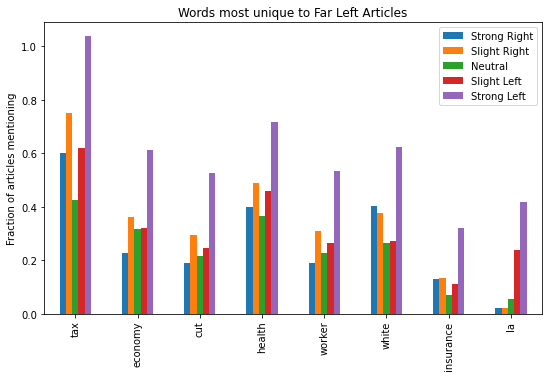

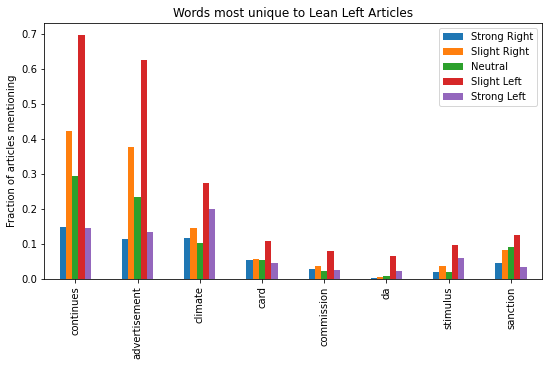

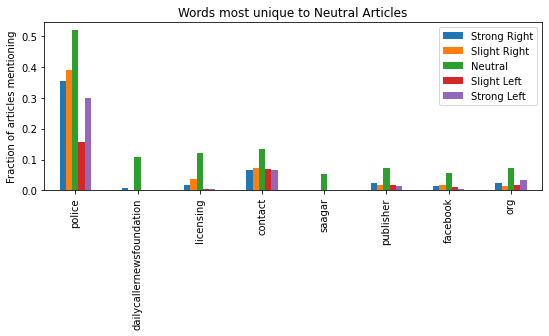

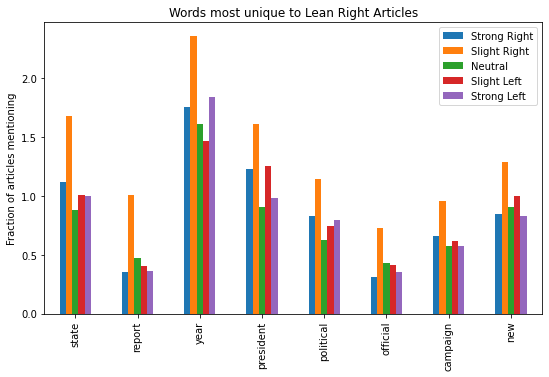

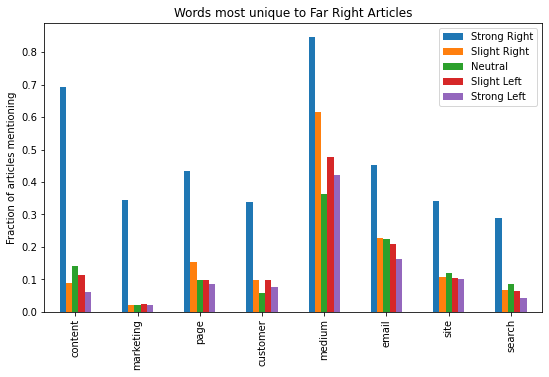

In [10]:
numOfEach = 8 #Top number of words to display

#Show plots of the frequencies of the most unique words for each rating

dfuniquevl = df.sort_values("uniqueVL",ascending=False).filter(["Strong Right","Slight Right","Neutral","Slight Left","Strong Left"]).head(numOfEach)
dfuniquevl.plot.bar()
plt.title("Words most unique to Far Left Articles")
plt.ylabel("Fraction of articles mentioning")
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.savefig("uniquevl.png",dpi=100)
plt.show()

dfuniquevl = df.sort_values("uniqueSL",ascending=False).filter(["Strong Right","Slight Right","Neutral","Slight Left","Strong Left"]).head(numOfEach)
dfuniquevl.plot.bar()
plt.title("Words most unique to Lean Left Articles")
plt.ylabel("Fraction of articles mentioning")
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.savefig("uniquesl.png",dpi=100)
plt.show()

dfuniquevl = df.sort_values("uniqueN",ascending=False).filter(["Strong Right","Slight Right","Neutral","Slight Left","Strong Left"]).head(numOfEach)
dfuniquevl.plot.bar()
plt.title("Words most unique to Neutral Articles")
plt.ylabel("Fraction of articles mentioning")
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.savefig("uniquen.png",dpi=100)
plt.show()

dfuniquevl = df.sort_values("uniqueSR",ascending=False).filter(["Strong Right","Slight Right","Neutral","Slight Left","Strong Left"]).head(numOfEach)
dfuniquevl.plot.bar()
plt.title("Words most unique to Lean Right Articles")
plt.ylabel("Fraction of articles mentioning")
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.savefig("uniquesr.png",dpi=100)
plt.show()

dfuniquevl = df.sort_values("uniqueVR",ascending=False).filter(["Strong Right","Slight Right","Neutral","Slight Left","Strong Left"]).head(numOfEach)
dfuniquevl.plot.bar()
plt.title("Words most unique to Far Right Articles")
plt.ylabel("Fraction of articles mentioning")
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.savefig("uniquevr.png",dpi=100)
plt.show()